## **N Multi-Modal Sensors with Universal Encoding Simulation **

### **Overview**
This Jupyter Notebook simulates and analyzes the behavior of multi-modal sensors within a defined geographical region using temperature, u-wind (East-West), and v-wind (North-South) data extracted from NetCDF files. The analysis involves encoding sensor data, evaluating adaptive reporting efficiencies, and visualizing sensor placement relative to a central hub.

---

### **Objectives**
1. **Randomized Sensor Simulation**:  
   - Select random sensor locations from the dataset grid.  
   - Simulate multi-modal sensors capable of reporting **temperature**, **u-wind**, and **v-wind** data.

2. **Data Encoding**:  
   - Use a **Universal Encoding Framework** to normalize sensor readings into symbolic representations.  
   - Encode adaptive reporting based on granularity thresholds for temperature and wind values.

3. **Efficiency Analysis**:  
   - Compare the efficiency of **adaptive reporting** vs. **fixed-interval reporting** for sensor data transmission.  
   - Calculate metrics such as **volume of transmitted data**, **efficiency gain**, and **distance-to-volume ratio**.

4. **Visualization**:  
   - **Sensor Distribution**: Plot sensor locations alongside the spatial extents of the dataset and a defined central hub.  
   - Annotate sensors with their **ID numbers** and distances to the hub for clarity.

---

### **Methods**
1. **Haversine Formula**:  
   - Calculate the geographical distance (in kilometers) between sensors and the central hub.

2. **Adaptive Reporting Logic**:  
   - **Temperature**:  
     - Fine (1°C) reporting below 20°C.  
     - Coarse (2°C) reporting for 20–30°C.  
     - Logarithmic reporting above 30°C.  
   - **Wind**:  
     - Fine (0.5 m/s) reporting below 5 m/s.  
     - Coarse (1 m/s) reporting above 5 m/s.

3. **Universal Encoding Framework**:  
   - Normalize sensor values within defined ranges for temperature and wind.  

4. **Randomized Sensor Selection**:  
   - Select random grid cells to simulate sensor placements, ensuring coverage across the dataset.  

5. **Visualization Tools**:  
   - **Sensor Placement Plot**: Visualize sensor positions, annotate with **Sensor ID** and **distance to hub**, and overlay data extents.  
   - **Efficiency Gain Plot**: Compare the efficiency of adaptive and fixed reporting approaches for each sensor.

---

### **Dependencies**
- **Python Libraries**:  
   - `xarray`, `pandas`, `numpy`, `matplotlib`  

---

### **Outputs**
1. **Encoded Sensor Reports**:  
   - A DataFrame with normalized sensor values and metadata (sensor type, time, and sensor ID).  

2. **Sensor Network Summary**:  
   - Summary report including adaptive and fixed data volumes, efficiency gain, and distance-to-volume metrics.  

3. **Plots**:
   - **Sensor Locations**: Map sensor positions and annotate them with IDs and distances.  
   - **Efficiency Gain**: Bar chart comparing efficiency gains for adaptive vs. fixed reporting.

---

### **Visualizations**
1. **Sensor Placement Plot**:  
   - Visualize sensor locations relative to the central hub.  
   - Annotate each sensor with both its **Sensor ID** and its **distance** to the hub.

2. **Efficiency Gain Bar Chart**:  
   - Compare data transmission efficiency for each sensor.

---

### **Use Case**
This notebook serves as a foundation for **IoT sensor network optimization** in spatially distributed environments. It highlights how adaptive data encoding can improve efficiency while maintaining data fidelity, which is crucial for applications like **environmental monitoring**, **wildfire detection**, and **climate analysis**.

---



In [4]:
import xarray as xr
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from math import radians, cos, sin, sqrt, atan2


# Step 1: Define paths and group files by variable
data_dir = "../data/NetCDF"  # Adjust path as needed
file_groups = {
    "temperature": ["April-30-temp.nc", "May-01-temp.nc", "May-02-temp.nc", "May-03-temp.nc"],
    "u_wind": ["April-30-u-wind.nc", "May-01-u-wind.nc", "May-02-u-wind.nc", "May-03-u-wind.nc"],
    "v_wind": ["April-30-v-wind.nc", "May-01-v-wind.nc", "May-02-v-wind.nc", "May-03-v-wind.nc"]
}

# Step 2: Function to load and combine NetCDF files for each variable
def load_and_combine_netcdf(file_list, variable_name, data_dir):
    """
    Load multiple NetCDF files for a given variable and combine them into a single DataFrame.
    """
    combined_df = []
    for file in file_list:
        file_path = os.path.join(data_dir, file)
        print(f"Loading {variable_name} data from: {file_path}")
        
        # Open NetCDF file and convert to DataFrame
        ds = xr.open_dataset(file_path)
        df = ds.to_dataframe().reset_index()
        
        # Drop missing values and rename the variable column
        df = df.dropna().rename(columns={list(ds.data_vars.keys())[0]: "value"})
        df["variable"] = variable_name  # Add variable name column
        combined_df.append(df)
    
    # Combine all DataFrames
    final_df = pd.concat(combined_df, ignore_index=True)
    return final_df

# Step 3: Load and combine data for each variable
print("Loading and combining Temperature files...")
temperature_df = load_and_combine_netcdf(file_groups["temperature"], "temperature", data_dir)

print("\nLoading and combining U-Wind files...")
u_wind_df = load_and_combine_netcdf(file_groups["u_wind"], "u_wind", data_dir)

print("\nLoading and combining V-Wind files...")
v_wind_df = load_and_combine_netcdf(file_groups["v_wind"], "v_wind", data_dir)

Loading and combining Temperature files...
Loading temperature data from: ../data/NetCDF/April-30-temp.nc
Loading temperature data from: ../data/NetCDF/May-01-temp.nc
Loading temperature data from: ../data/NetCDF/May-02-temp.nc
Loading temperature data from: ../data/NetCDF/May-03-temp.nc

Loading and combining U-Wind files...
Loading u_wind data from: ../data/NetCDF/April-30-u-wind.nc
Loading u_wind data from: ../data/NetCDF/May-01-u-wind.nc
Loading u_wind data from: ../data/NetCDF/May-02-u-wind.nc
Loading u_wind data from: ../data/NetCDF/May-03-u-wind.nc

Loading and combining V-Wind files...
Loading v_wind data from: ../data/NetCDF/April-30-v-wind.nc
Loading v_wind data from: ../data/NetCDF/May-01-v-wind.nc
Loading v_wind data from: ../data/NetCDF/May-02-v-wind.nc
Loading v_wind data from: ../data/NetCDF/May-03-v-wind.nc


Processing Sensor 140: (56.45, -110.75)
Processing Sensor 114: (56.55, -111.95)
Processing Sensor 17: (57.25, -111.85)
Processing Sensor 76: (56.85, -111.55)
Processing Sensor 155: (56.25, -112.05)
Processing Sensor 186: (56.05, -111.75)
Processing Sensor 70: (56.95, -110.75)
Processing Sensor 56: (57.05, -110.75)
Processing Sensor 19: (57.25, -111.65)
Processing Sensor 170: (56.15, -111.95)

Universal Encoded Outputs:
   sensor_type  encoded_value       units  raw_value      range  resolution  \
0  temperature          3.415  normalized    291.461  (-50, 50)           3   
1       u_wind          0.485  normalized     -0.585  (-20, 20)           3   
2       v_wind          0.582  normalized      3.271  (-20, 20)           3   
3  temperature          3.407  normalized    290.695  (-50, 50)           3   
4       u_wind          0.481  normalized     -0.766  (-20, 20)           3   
5       v_wind          0.571  normalized      2.839  (-20, 20)           3   

                 time  

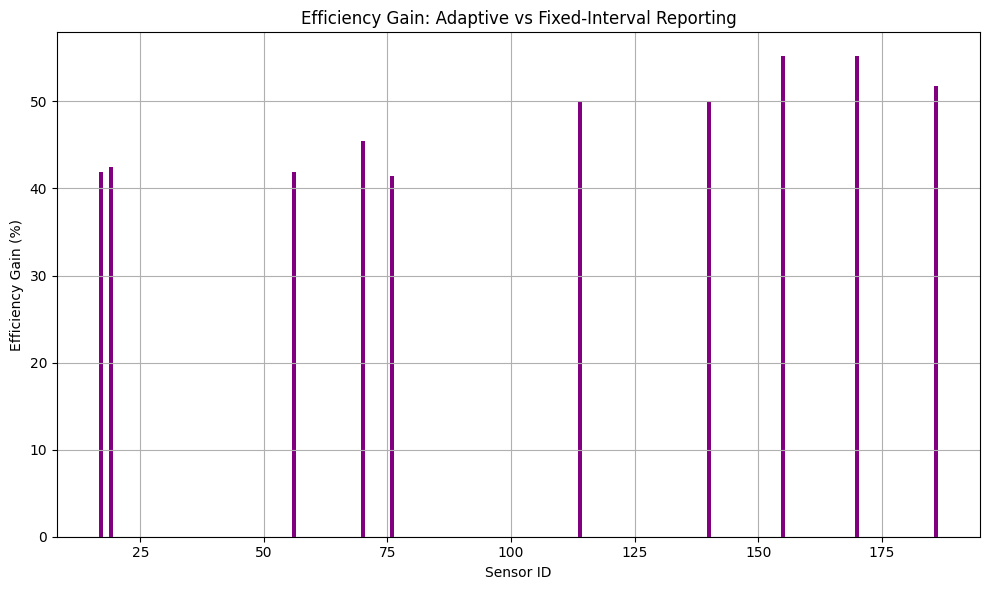

In [5]:
# Define the central hub location (average grid center)
central_lat, central_lon = 56.75, -111.25  # Adjust based on dataset mean values

# Haversine formula to compute distance between two latitude-longitude points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2.0) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2.0) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Adaptive reporting logic
def adaptive_reporting(value, sensor_type):
    """
    Adaptive reporting logic for temperature and wind data:
       - Temperature: Fine (1°C) below 20°C, Coarse (2°C) for 20°C-30°C, Logarithmic beyond 30°C.
       - Wind: Fine (0.5 m/s) below 5 m/s, Coarse (1 m/s) beyond 5 m/s.
    """
    if sensor_type == "temperature":
        if value < 20:
            return round(value)
        elif 20 <= value <= 30:
            return round(value / 2) * 2
        elif value > 30:
            return round(value / 5) * 5
    elif sensor_type in ["u_wind", "v_wind"]:
        if value < 5:
            return round(value * 2) / 2  # Report to nearest 0.5 m/s
        else:
            return round(value)
    return value

# Universal Encoding Framework
def universal_encoder(sensor_type, value, min_range, max_range, precision=3):
    """
    Encodes a sensor value into a normalized symbolic representation.
    """
    normalized_value = round((value - min_range) / (max_range - min_range), precision)
    encoded_output = {
        "sensor_type": sensor_type,
        "encoded_value": normalized_value,
        "units": "normalized",
        "raw_value": round(value, precision),
        "range": (min_range, max_range),
        "resolution": precision
    }
    return encoded_output

# Function to simulate and encode n multi-modal sensors with random distribution
def simulate_and_encode_sensors(n_sensors, temp_df, u_wind_df, v_wind_df):
    np.random.seed(42)  # Ensure repeatability
    
    # Randomly sample sensor locations from available grid cells
    unique_locations = temp_df[["latitude", "longitude"]].drop_duplicates()
    sensor_locations = unique_locations.sample(n=min(n_sensors, len(unique_locations)), random_state=42)

    encoded_reports = []
    report_list = []

    for idx, row in sensor_locations.iterrows():
        sensor_lat, sensor_lon = row["latitude"], row["longitude"]
        print(f"Processing Sensor {idx + 1}: ({sensor_lat:.2f}, {sensor_lon:.2f})")

        # Extract data for temperature, u-wind, and v-wind
        temp_data = temp_df[(temp_df["latitude"] == sensor_lat) & (temp_df["longitude"] == sensor_lon)]
        u_wind_data = u_wind_df[(u_wind_df["latitude"] == sensor_lat) & (u_wind_df["longitude"] == sensor_lon)]
        v_wind_data = v_wind_df[(v_wind_df["latitude"] == sensor_lat) & (v_wind_df["longitude"] == sensor_lon)]

        # Merge all data by time
        merged_data = temp_data[["valid_time", "value"]].rename(columns={"value": "temperature"})
        merged_data = merged_data.merge(u_wind_data[["valid_time", "value"]].rename(columns={"value": "u_wind"}),
                                        on="valid_time", how="inner")
        merged_data = merged_data.merge(v_wind_data[["valid_time", "value"]].rename(columns={"value": "v_wind"}),
                                        on="valid_time", how="inner")

        # Encode sensor readings
        for _, row in merged_data.iterrows():
            time = row["valid_time"]
            encoded_temp = universal_encoder("temperature", row["temperature"], -50, 50)
            encoded_u = universal_encoder("u_wind", row["u_wind"], -20, 20)
            encoded_v = universal_encoder("v_wind", row["v_wind"], -20, 20)
            encoded_temp["time"] = encoded_u["time"] = encoded_v["time"] = time
            encoded_temp["Sensor ID"] = encoded_u["Sensor ID"] = encoded_v["Sensor ID"] = idx + 1
            encoded_reports.extend([encoded_temp, encoded_u, encoded_v])

        # Adaptive and fixed reporting volumes
        adaptive_temp = len(set(adaptive_reporting(v, "temperature") for v in merged_data["temperature"])) * 4
        fixed_temp = len(set(round(v) for v in merged_data["temperature"])) * 4

        adaptive_wind = len(set(adaptive_reporting(v, "u_wind") for v in merged_data["u_wind"])) * 4
        fixed_wind = len(set(round(v) for v in merged_data["u_wind"])) * 4

        distance_to_hub = haversine(sensor_lat, sensor_lon, central_lat, central_lon)
        adaptive_efficiency = distance_to_hub / (adaptive_temp + adaptive_wind)
        fixed_efficiency = distance_to_hub / (fixed_temp + fixed_wind)

        report_list.append({
            "Sensor ID": idx + 1,
            "Latitude": sensor_lat,
            "Longitude": sensor_lon,
            "Adaptive Volume (Bytes)": adaptive_temp + adaptive_wind,
            "Fixed Volume (Bytes)": fixed_temp + fixed_wind,
            "Efficiency Gain (%)": round((fixed_temp + fixed_wind - adaptive_temp - adaptive_wind) /
                                         (fixed_temp + fixed_wind) * 100, 2),
            "Adaptive Efficiency (km/Byte)": round(adaptive_efficiency, 6),
            "Fixed Efficiency (km/Byte)": round(fixed_efficiency, 6)
        })

    # Return the encoded reports and summary
    encoded_df = pd.DataFrame(encoded_reports)
    summary_df = pd.DataFrame(report_list)
    return encoded_df, summary_df


# Run the multi-modal sensor simulation
n_sensors = 10
encoded_results, summary_report = simulate_and_encode_sensors(n_sensors, temperature_df, u_wind_df, v_wind_df)

# Display results
print("\nUniversal Encoded Outputs:")
print(encoded_results.head(6))

print("\nSensor Network Summary Report:")
print(summary_report)

# Plot Efficiency Gain
plt.figure(figsize=(10, 6))
plt.bar(summary_report["Sensor ID"], summary_report["Efficiency Gain (%)"], color="purple")
plt.title("Efficiency Gain: Adaptive vs Fixed-Interval Reporting")
plt.xlabel("Sensor ID")
plt.ylabel("Efficiency Gain (%)")
plt.grid()
plt.tight_layout()
plt.show()


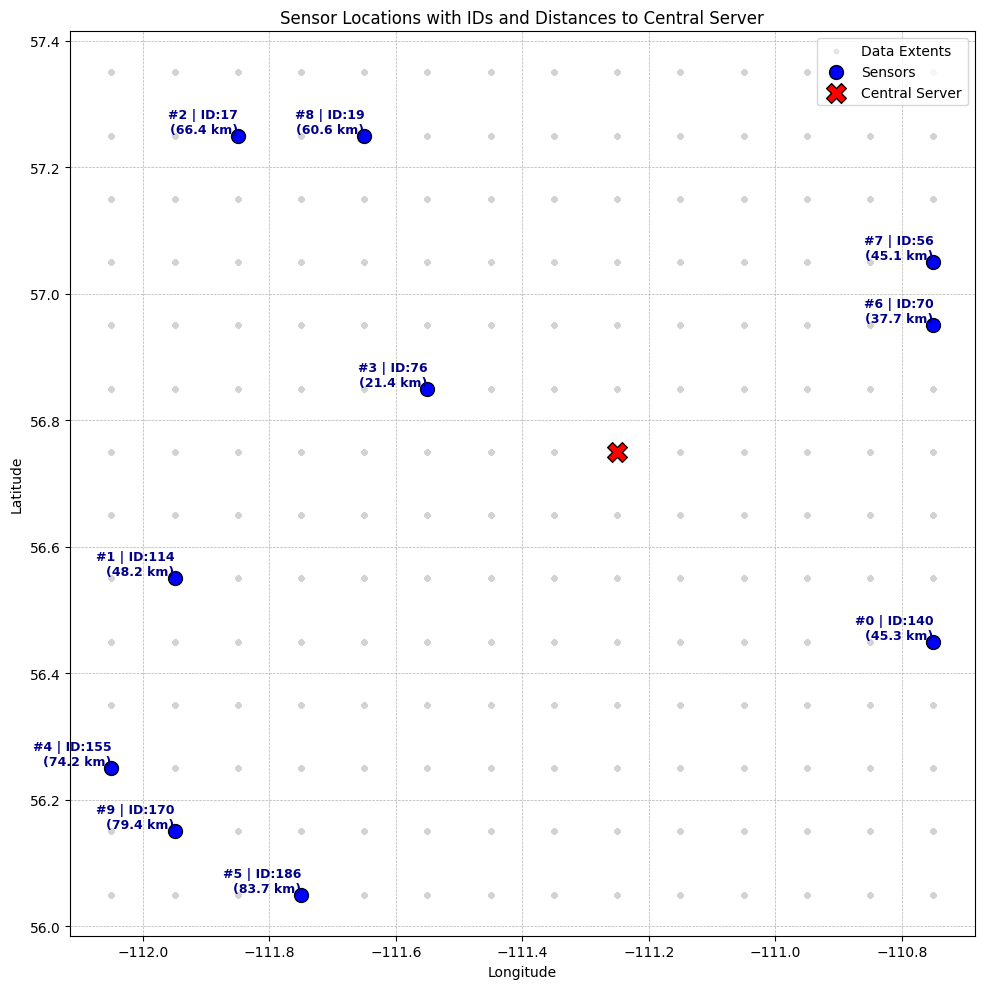

In [6]:
import matplotlib.pyplot as plt
from math import radians, cos, sin, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great-circle distance between two points using the Haversine formula."""
    R = 6371.0  # Radius of Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Define the central hub location (manual or dataset mean)
central_lat, central_lon = 56.75, -111.25

# Extract sensor locations and distances
sensor_latitudes = summary_report["Latitude"].values
sensor_longitudes = summary_report["Longitude"].values
sensor_ids = summary_report["Sensor ID"].values
id_numbers = summary_report.index.values  # Assuming ID # is the index

# Calculate distances to the central hub
distances = [haversine(central_lat, central_lon, lat, lon)
             for lat, lon in zip(sensor_latitudes, sensor_longitudes)]

# Plot sensor locations and the central server
def plot_sensor_locations_with_ids(temp_df, sensor_latitudes, sensor_longitudes, sensor_ids, id_numbers,
                                   central_lat, central_lon, distances):
    plt.figure(figsize=(10, 10))  # Square figure dimensions

    # Plot spatial extents of the data
    plt.scatter(temp_df["longitude"], temp_df["latitude"],
                color="lightgrey", alpha=0.5, s=10, label="Data Extents")

    # Plot sensor locations
    plt.scatter(sensor_longitudes, sensor_latitudes,
                c="blue", s=100, edgecolor="black", label="Sensors")

    # Plot the central server
    plt.scatter(central_lon, central_lat,
                c="red", s=200, marker="X", edgecolor="black", label="Central Server")

    # Annotate sensors with Sensor ID, ID #, and distance
    for i, (lat, lon, sid, id_num, dist) in enumerate(zip(sensor_latitudes, sensor_longitudes,
                                                         sensor_ids, id_numbers, distances)):
        plt.text(lon, lat, f"#{id_num} | ID:{sid}\n({dist:.1f} km)", fontsize=9,
                 ha="right", va="bottom", color="darkblue", fontweight="bold")

    # Stretch latitude axis to make the plot square
    plt.gca().set_aspect('equal', adjustable='box')

    # Set plot titles, grid, and labels
    plt.title("Sensor Locations with IDs and Distances to Central Server")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(loc="upper right")
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Call the updated function to plot
plot_sensor_locations_with_ids(temperature_df, sensor_latitudes, sensor_longitudes,
                               sensor_ids, id_numbers, central_lat, central_lon, distances)
